# Part 3 Machine Learning - Aproach 1 & 2

To predict the wine scores, I used three classification models: Logistic Regression, Random Forest, and XGboost.

This jupyter notebook is my initial attempt at predicting the wine scores. Complications became apparent when running the machine learning algorthims. I had realized that I had setup the train/set dataset incorrectly from the Part 2 jupyter notebook. Approach 1 and 2 methods for handling the one hot encoding process are described in the AStern_Part2_NLP_Wine_Reviews.ipynb for reference. 

I am providing this notebook as a reference in providing all of my steps and workflow processes. This jupyter notebook is not to be used for future work. Instead, use AStern_Part3B_ML.

In [1]:
# Some basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For splitting our data
from sklearn.model_selection import train_test_split

# For some simple model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This gets rid of those annoying default solver messages when fitting logistic regression
import warnings
warnings.filterwarnings('ignore')

# For cross-validation
from sklearn.model_selection import cross_val_score

# For setting up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# Pipeline
from sklearn.pipeline import Pipeline

# Some scalers we'll try later
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# For trying PCA later
from sklearn.decomposition import PCA

# For cross-validated grid search
from sklearn.model_selection import GridSearchCV

In [2]:
# import data
train = pd.read_csv('data/model_train.csv')
test = pd.read_csv('data/model_test.csv')

In [3]:
# This is train datasett
X = train.drop('points', axis = 1)
y = train['points']

# This is train datasett
X_test = test.drop('points', axis = 1)
y_test = test['points']

# Approach 2 for NLP

This dataset is from when I used Approach 2 to transform the Country, Province, and Variety into numeric values through get_dummies. I created a threshold to only include contries, provinces, and wine varieties that frequently appeared in the dataset. By doing this the dataset reduced from 42 countries to 12 countries, 406 provinces to 34 provinces, and 646 varieties to only 34 varieties! 

In [46]:
# Baseline logistic regression
baseline_logreg = LogisticRegression(random_state=1).fit(X_train, y_train)

print(f'Accuracy on remainder set: {baseline_logreg.score(X_train, y_train)}')
print(f'Accuracy on remainder set: {baseline_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.5322905490616824
Accuracy on remainder set: 0.5276013678553981


The accuracy score for the train set is 53.2% and the accuracy score for the test set is 52.7%. This is not comforting to see as the original accuracy score was 80% from Approach 1. As well an accuraacy score of 50% is not beneficial for predicing wine scores espcially when there are only two classifications to predict.

Complete a little more further anlysis with hyperparameterization train and test dataset from Approach 2:

In [75]:
# Deteremine which c_value is best for a logistic regression model
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# For loop
for value in c_values:
    
    # Instantiate log reg and fit to train set
    logreg = LogisticRegression(C=value, random_state=1).fit(X_train, y_train)
    
    # Score on train set and append accuracy
    train_accuracies.append(logreg.score(X_train, y_train))
    
    # Score on validation set and append accuracy
    validation_accuracies.append(logreg.score(X_val, y_val))

In [76]:
# Check the accuracies
pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

,C value,train accuracy,validation accuracy
0,0.00001,0.528658,0.528685
1,0.00010,0.528658,0.528685
2,0.00100,0.528658,0.528685
3,0.10000,0.532272,0.528836
4,1.00000,0.532291,0.528685
5,10.00000,0.532328,0.528610
6,100.00000,0.532366,0.528610
7,1000.00000,0.534022,0.525448
8,10000.00000,0.532366,0.528610


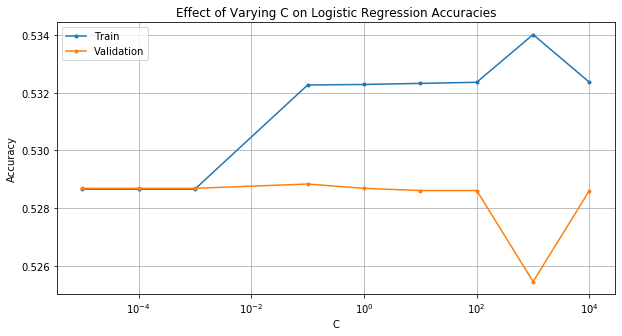

In [77]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # This is important for making the plot much more readable
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

For this dataset C = .001 however this is for when cross validation is not completed or scaling.

In [80]:
# This lets us "pickle" things, like accuracies in this case or even an entire fitted model 
import joblib

#### Let's see if the model will improve when fed through a pipeline

In [93]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
param_grid = [
    
    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [10, 20, 40, 60, 80, 100],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=param_grid, n_jobs = -1, cv=5, verbose=10)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

In [95]:
# Best model attributes
fitted_logreg_gs.best_estimator_

Pipeline(memory='/var/folders/5y/d61vfhqx3bv7m_5qfsqw1g8c0000gn/T/tmphlar0iv1',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-05, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=1, solver='lbfgs', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

The best estimator model is when a StandardScaler is used, PCA n_components = 10, and C = 1e-5

In [97]:
# Accuracy score for train data
fitted_logreg_gs.score(X_train, y_train)

0.5286577446496132

In [98]:
# Accuracy score for validation data
fitted_logreg_gs.score(X_val, y_val)

0.5286854389399187

Even after running a pipline which can incorporate scaling and cross validation at the same time, the accuracy score is still only 52%.

In [99]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory = cachedir)

#### Let's try with a random forest through a pipeline to see any improvements in the accruacy score will be made.

In [102]:
# n_estimators
n_estimator = [10, 20, 40, 60, 80, 100, 120, 140, 160]

# Parameter grid
param_grid = [

    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [10, 20, 40, 60, 80, 100],
     'model': [RandomForestClassifier(n_jobs = -1)],
     'model__n_estimators': n_estimator}
]

# Instantiate the log reg grid search
random_forest_gs = GridSearchCV(my_pipeline, param_grid=param_grid, n_jobs = -1, cv=5, verbose=10)

# Fit the log reg grid search
fitted_randomforest_gs = random_forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 40

In [103]:
fitted_randomforest_gs.best_estimator_

Pipeline(memory='/var/folders/5y/d61vfhqx3bv7m_5qfsqw1g8c0000gn/T/tmpkaj9ki6i',
         steps=[('scaler', None),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=140, n_jobs=-1,
                           

Best estimator for a random forest is when n_components = 100, scaler is none, and n_estimator = 140

In [104]:
# Accuracy Score for tain
fitted_randomforest_gs.score(X_train, y_train)

0.9779584768573418

In [105]:
# Accuracy score for random forest
fitted_randomforest_gs.score(X_val, y_val)

0.5163379009185364

In [106]:
# Accuracy score for test
fitted_randomforest_gs.score(X_test, y_test)

0.5122129946262823

We can see here that the accuracy score is a 97% for the train dataset, which might seem good but by looking at the accuracy scores for the test and validation set we see that the accuracy score is 51% which means that the model is overfitting for the train dataset. Therefore the random forest was not an improvement from the logistic regression.

I did not run a XGboost model on this dataset because while XGboost could potentially improve the model, it is not going to improve the model by 30-40% which is what I would like to see. Therefore we can determine that removing the variation in the countries, province, and variety hindered the accuracy score. Back to the drawing board!

# Approach 1

#### A. Random Forest

Pipline/Gridsearch to find best accuracy

In [24]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory = cachedir)
# Let's try the same range of C values from earlier
n_estimator = [300]

# Parameter grid
param_grid = [

    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [100],
     'model': [RandomForestClassifier(n_jobs = -1)],
     'model__n_estimators': n_estimator}
]

In [25]:
# Instantiate the log reg grid search
random_forest_gs = GridSearchCV(my_pipeline, param_grid=param_grid, n_jobs = -1, cv=5, verbose=10)

In [26]:
# Fit the log reg grid search
fitted_randomforest_gs = random_forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 40.5min remaining: 20.3min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 42.2min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 48.6min finished


In [27]:
print('train accuracy:', fitted_randomforest_gs.score(X_train, y_train))
print('valdiation accuracy:', fitted_randomforest_gs.score(X_val, y_val))

train accuracy: 0.9999862605278705
valdiation accuracy: 0.8039679050340734


Accuracy score of train set is 99% and validation score is 80% which indicates that the model is overfitting.

In [52]:
## CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

y_pred = fitted_randomforest_gs.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[7972, 1637],
       [1785, 6802]])

Confusion matrix provides insights into how well the model performed in terms of predicting True positives and true negatives. We can see from the above tha the model correctly predicted True negatives (where points = 0) of 7972 and incorrectly predicted 1785 reviews as negative. The model correctly predicted 6802 as positive scores and incorectly predictetd 1637 as positive scores.

As expected the model did a better job at predicting the negative scores than the positive scores (explained in Part 2 of the project).

### Model Evaluation

In [53]:
### Accuracy Score for validation set
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred)

0.8119366893822818

In [54]:
# Precision Score for Validation Set
from sklearn.metrics import precision_score

# precision_score(true labels, predicted labels)
precision_score(y_val, y_pred)

0.8060196705770826

In [55]:
# Recall Score for Validation set
from sklearn.metrics import recall_score

# recall_score(true labels, predicted labels)
recall_score(y_val, y_pred)

0.7921276347967858

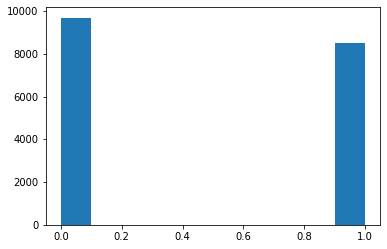

In [36]:
# View in a plot how the y validation data is predicted.
plt.figure()
plt.hist(Ypredict)
plt.show()

Accuracy score for Test dataset cannot be completed because the X_test has a different size matrix than the train dataset because the train and test set contain different features. The different features are from when splitting the train and test set, there were 

In [26]:
fitted_randomforest_gs.score(X_test, y_test)

ValueError: operands could not be broadcast together with shapes (38992,1348) (1325,) 

The error indicates that the Test size and Train size are not the same shape. We can see this below as well. While the rows do not need to be the same size, the columns and feature names need to be the same for test and train dataset. This is something that I did not consider checking when I ran the one hot encoding. For tfidf this is not a problem because I fit the tfidf vectorizer to the train set and then transform the test set from the fit.

In [76]:
X_test.shape

(38992, 1132)

In [78]:
X_train.shape

(72783, 1325)

#### Logistic Regression

In [96]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory = cachedir)


# Let's try the same range of C values from earlier
c_values = c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]


# Parameter grid
logreg_param_grid = [

    # l2 (default) with PCA
    {'scaler': [RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [1, 10, 100, 200, 300, 400],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
]

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, n_jobs = -1, cv=5, verbose=10)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 17

In [97]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='/var/folders/5y/d61vfhqx3bv7m_5qfsqw1g8c0000gn/T/tmpxxhifh7x',
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=300,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=1, solver='lbfgs', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [98]:
print(f"The best logistic regression's accuracy on the remainder set: {fitted_logreg_gs.score(X_train, y_train)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_val, y_val)}")

The best logistic regression's accuracy on the remainder set: 0.7933995575889974
The best logistic regression's accuracy on the test set: 0.7908331501428886


After running many different models from, I was able to get the best_estimator for logistic regression. I did not originally save the model as a pkl therefore I needed to run the best fitting model again to be able to evaluate the model with precision and recall.

In [56]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory = cachedir)


# Let's try the same range of C values from earlier
c_values = [1000]


# Parameter grid
logreg_param_grid = [

    # l2 (default) with PCA
    {'scaler': [RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [300],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
]

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, n_jobs = -1, cv=5, verbose=10)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


In [58]:
# Accuracy Score of the model from the train dataset
fitted_logreg_gs.score(X_train, y_train)

0.7940040943626946

#### Model Evaluation for Logistic Regression

In [62]:
# Accuracy scores for logistic regression for validation set:
y_pred = fitted_logreg_gs.predict(X_val)
print('accuracy score for logistic regression', fitted_logreg_gs.score(X_val, y_val))
# precision_score(true labels, predicted labels)
print('precision score for logistic regression', precision_score(y_val, y_pred))
# recall_score(true labels, predicted labels)
print('recall score for logistic regression', recall_score(y_val, y_pred))

accuracy score for logistic regression 0.791272807210376
precision score for logistic regression 0.7871447415757286
recall score for logistic regression 0.7644113194363573


#### C. XGBOOST

In [64]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory = cachedir)


# Parameter grid
param_grid = [
    
    # XGB Boost
    {'scaler': [StandardScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [100, 200, 300],
     'model': [XGBClassifier()]}
    
]

# Instantiate the log reg grid search
xgboost_gs = GridSearchCV(my_pipeline, param_grid=param_grid, n_jobs = -1, cv=5, verbose=10)

# Fit the log reg grid search
fitted_xgboost_gs = xgboost_gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 76.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 121.5min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 124.4min finished


In [68]:
fitted_xgboost_gs.best_estimator_

Pipeline(memory='/var/folders/5y/d61vfhqx3bv7m_5qfsqw1g8c0000gn/T/tmpnbrfy5v_',
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=300,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                       

#### Model Evaluation for XGboost

In [66]:
# Accuracy scores for logistic regression for validation set:
y_pred = fitted_xgboost_gs.predict(X_val)
print('accuracy score for logistic regression', fitted_xgboost_gs.score(X_val, y_val))
# precision_score(true labels, predicted labels)
print('precision score for logistic regression', precision_score(y_val, y_pred))
# recall_score(true labels, predicted labels)
print('recall score for logistic regression', recall_score(y_val, y_pred))

accuracy score for logistic regression 0.7758298527148824
precision score for logistic regression 0.7652388797364086
recall score for logistic regression 0.7573075579364155
